In [22]:
import cv2
import numpy as np
import pytesseract
import pandas as pd
import json
import re
import matplotlib.pyplot as plt
from pdf2image import convert_from_path

In [23]:
PDF_PATH = r"C:\Users\HP\Downloads\sample.pdf"
POPPLER_PATH = r"C:\poppler-25.12.0\Library\bin"
TESSERACT_PATH = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

pytesseract.pytesseract.tesseract_cmd = TESSERACT_PATH

In [24]:
def clean_text(text):

    text = text.replace("°", "")
    text = text.replace("”", "")
    text = text.replace("|", "")

    if len(text.strip()) <= 2:
        return ""

    if not any(char.isalnum() for char in text):
        return ""

    if re.match(r'^\d+-\d+$', text):
        text = text.replace("-", ".")

    return text.strip()

In [25]:
def get_column_centers(table, threshold=60):

    centers = []

    for row in table:
        for box in row:
            x, y, w, h = box
            centers.append(x + w // 2)

    if not centers:
        return []

    centers = sorted(centers)

    clustered = []
    current_cluster = [centers[0]]

    for c in centers[1:]:
        if abs(c - np.mean(current_cluster)) < threshold:
            current_cluster.append(c)
        else:
            clustered.append(int(np.mean(current_cluster)))
            current_cluster = [c]

    clustered.append(int(np.mean(current_cluster)))

    return clustered

In [26]:
pages = convert_from_path(
    PDF_PATH,
    dpi=300,
    poppler_path=POPPLER_PATH
)

print(f"total Pages: {len(pages)}")

total Pages: 11


In [27]:
PAGE_INDEX = 3 

image = np.array(pages[PAGE_INDEX])
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

print("PDF loaded")

PDF loaded


Preprocessing donee


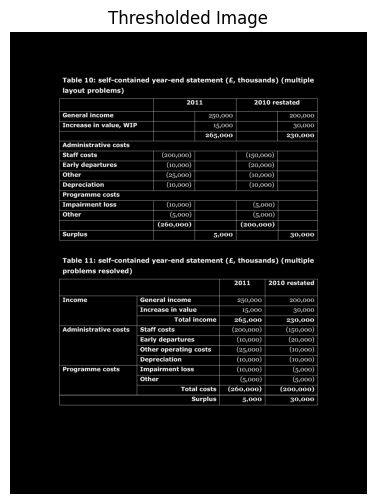

In [28]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

thresh = cv2.adaptiveThreshold(
    gray,
    255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV,
    15,
    4
)

plt.figure(figsize=(8,6))
plt.imshow(thresh, cmap="gray")
plt.title("Thresholded Image")
plt.axis("off")

print("Preprocessing donee")


(np.float64(-0.5), np.float64(2549.5), np.float64(3299.5), np.float64(-0.5))

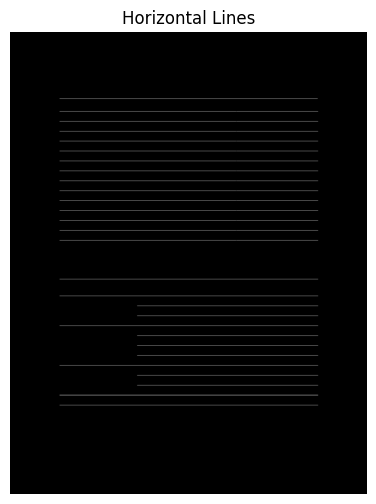

In [29]:

horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1))
horizontal_lines = cv2.morphologyEx(
    thresh,
    cv2.MORPH_OPEN,
    horizontal_kernel,
    iterations=2
)

plt.figure(figsize=(8,6))
plt.imshow(horizontal_lines, cmap="gray")
plt.title("Horizontal Lines")
plt.axis("off")


(np.float64(-0.5), np.float64(2549.5), np.float64(3299.5), np.float64(-0.5))

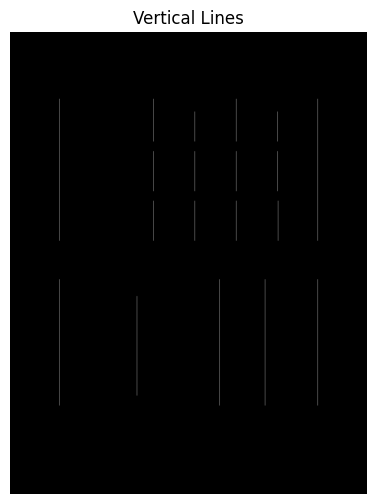

In [30]:
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 40))
vertical_lines = cv2.morphologyEx(
    thresh,
    cv2.MORPH_OPEN,
    vertical_kernel,
    iterations=2
)

plt.figure(figsize=(8,6))
plt.imshow(vertical_lines, cmap="gray")
plt.title("Vertical Lines")
plt.axis("off")

table structure detected


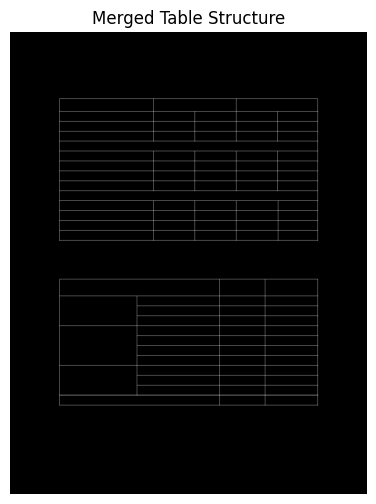

In [31]:
table_structure = cv2.add(horizontal_lines, vertical_lines)

plt.figure(figsize=(8,6))
plt.imshow(table_structure, cmap="gray")
plt.title("Merged Table Structure")
plt.axis("off")

print("table structure detected")

In [32]:
contours, _ = cv2.findContours(
    table_structure,
    cv2.RETR_TREE,
    cv2.CHAIN_APPROX_SIMPLE
)

boxes = []

for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if w > 50 and h > 20:
        boxes.append([x, y, w, h])

print("total cell boxes detected:", len(boxes))


total cell boxes detected: 101


(np.float64(-0.5), np.float64(2549.5), np.float64(3299.5), np.float64(-0.5))

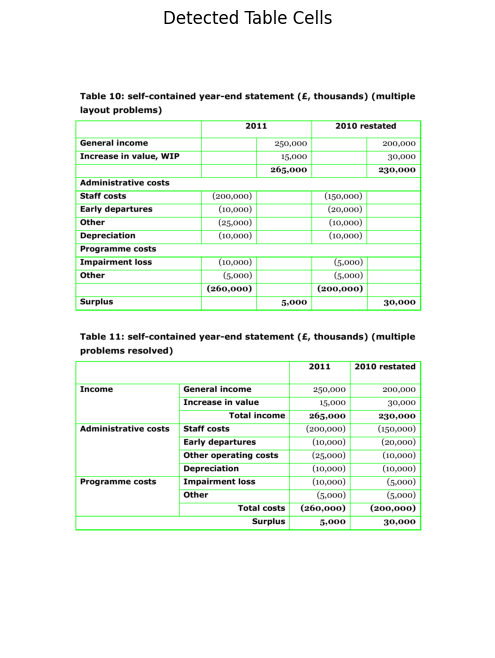

In [33]:
debug_img = image.copy()

for box in boxes:
    x, y, w, h = box
    cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0,255,0), 2)

plt.figure(figsize=(10,8))
plt.imshow(cv2.cvtColor(debug_img, cv2.COLOR_BGR2RGB))
plt.title("Detected Table Cells")
plt.axis("off")

In [34]:
boxes = sorted(boxes, key=lambda b: b[1])

rows = []
current_row = []
tolerance = 15

for box in boxes:
    if not current_row:
        current_row.append(box)
    else:
        if abs(box[1] - current_row[0][1]) < tolerance:
            current_row.append(box)
        else:
            rows.append(current_row)
            current_row = [box]

if current_row:
    rows.append(current_row)

for row in rows:
    row.sort(key=lambda b: b[0])

print("total rows detected:", len(rows))


total rows detected: 26


In [35]:
row_heights = [np.mean([box[3] for box in row]) for row in rows]
avg_row_height = np.mean(row_heights)

tables = []
current_table = [rows[0]]

for i in range(1, len(rows)):
    prev_y = np.mean([b[1] for b in rows[i - 1]])
    curr_y = np.mean([b[1] for b in rows[i]])

    gap = curr_y - prev_y

    if gap > avg_row_height * 2:
        tables.append(current_table)
        current_table = [rows[i]]
    else:
        current_table.append(rows[i])

tables.append(current_table)

print("total tables detected:", len(tables))

total tables detected: 2


In [36]:
all_tables_data = []

for table_index, table in enumerate(tables):

    column_centers = get_column_centers(table)
    num_cols = len(column_centers)

    table_data = []

    for row in table:

        row_data = [""] * num_cols

        for box in row:
            x, y, w, h = box
            padding = 4

            cell = image[
                y + padding:y + h - padding,
                x + padding:x + w - padding
            ]

            cell_gray = cv2.cvtColor(cell, cv2.COLOR_BGR2GRAY)

            cell_thresh = cv2.threshold(
                cell_gray,
                0,
                255,
                cv2.THRESH_BINARY + cv2.THRESH_OTSU
            )[1]

            cell_resized = cv2.resize(
                cell_thresh,
                None,
                fx=2,
                fy=2,
                interpolation=cv2.INTER_CUBIC
            )

            cell_center = x + w // 2

            col_index = min(
                range(len(column_centers)),
                key=lambda i: abs(cell_center - column_centers[i])
            )

            config = '--oem 1 --psm 7'


            text = pytesseract.image_to_string(
                cell_resized,
                config=config
            )

            row_data[col_index] = clean_text(text)

        table_data.append(row_data)

    table_data = [
        row for row in table_data
        if any(cell.strip() != "" for cell in row)
    ]

    all_tables_data.append(table_data)

print("\nextraction completed.")


extraction completed.


In [37]:
dataframes = []

for i, table in enumerate(all_tables_data):

    max_cols = max(len(row) for row in table)

    normalized_table = []
    for row in table:
        row = row + [""] * (max_cols - len(row))
        normalized_table.append(row)

    cleaned_table = []
    for row in normalized_table:
        if any(cell.strip() != "" for cell in row):
            cleaned_table.append(row)

    df = pd.DataFrame(cleaned_table)
    dataframes.append(df)

    print(f"\nTABLE {i+1}")
    display(df)



TABLE 1


,0,1,2,3,4,5,6
0,,,2011,,,2010 restated,
1,General income,,,"250,000",,,"200,000"
2,"Increase in value, WIP",,,"15,000",,,"30,000"
3,,,,"265,000",,,"230,000"
4,,,Administrative costs,,,,
5,Staff costs,"(200,000)",,,"(150,000)",,
6,Early departures,"(10,000)",,,"(20,000)",,
7,Other,"(25,000)",,,"(10,000)",,
8,Depreciation,"(10,000)",,,"(10,000)",,
9,,,Programme costs,,,,



TABLE 2


,0,1,2,3,4,5
0,,,,,2011,2010 restated
1,Income,,General income,,"250,000","200,000"
2,,,Increase in value,,"15,000","30,000"
3,,,Total income,,"265,000","230,000"
4,Administrative costs,,Staff costs,,"(200,000)","(150,000)"
5,,,Early departures,,"(10,000)","(20,000)"
6,,,Other operating costs,,"(25,000)","(10,000)"
7,,,Depreciation,,"(10,000)","(10,000)"
8,Programme costs,,Impairment loss,,"(10,000)","(5,000)"
9,,,Other,,"(5,000)","(5,000)"


In [38]:
import os

output_folder = "D:\\projects\\Intellifer\\extracted_output1"
os.makedirs(output_folder, exist_ok=True)

for i, df in enumerate(dataframes):
    csv_path = os.path.join(output_folder, f"table_{i+1}.csv")
    df.to_csv(csv_path, index=False)
    print(f"saved: {csv_path}")



saved: D:\projects\Intellifer\extracted_output1\table_1.csv
saved: D:\projects\Intellifer\extracted_output1\table_2.csv
